In [33]:
# ASCAT wind speed plotter (.nc only) (no directions/vectors plotted)
# Demo uses .nc from EUMETSAT (ASCAT-B) from TS Nadine (2024)

#file_path = 'ascat_20241019_030600_metopb_62716_eps_o_coa_3301_ovw.l2.nc'

# Dalilia - NRL matches own, but CIMSS/NHC does not
# Dalilia ASCAT B descending (COASTAL, 25km)  and HY2B from earlier
file_path = 'ascat_20250613_145400_metopb_66090_eps_o_coa_3301_ovw.l2.nc'
# NASA VERSION
#file_path = 'ascat_20250613_145400_metopb_66090_eps_o_coa_3301_ovw.l2.nc_'
# 25km
#file_path = 'ascat_20250613_145400_metopb_66090_eps_o_250_3301_ovw.l2.nc'
#file_path = 'hscat_20250613_115914_hy_2b__33343_o_250_4006_ovw_l2.nc'

#NOAA (coastwatch)
file_path = 'AS202516416Bds_WW.nc'
file_path = 'AS202516412Bds_WW.nc'

# Motivation:
# https://www.nhc.noaa.gov/archive/2024/al15/al152024.discus.003.shtml?
# Discussion cites above ASCAT-C pass having 34 kt winds for upgrading AL95 to TS Nadine (2024)
# Must be referencing "Coastal" product, as no 34-kt winds show up in ASCAT C 25 km product
# All 34+ kt winds in swathe fail variational quality control (winds are suspect per KNMI manual)
# NRL and KNMI (Multiplatform viewer) showed coastal winds. Only NESDIS shows 25 km default.
# No color/flag/marker for variational quality control flag on NRL/KNMI plots to notice it is suspect.
# Worse NRL doesn't show barbs, so could not tell it was suspect from the direction.

# There was other support for TS though (ADT, D-PRINT, MTCSWA, weatherflow observation)

In [29]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
import numpy as np


def generate_noaa_title(s):
    # Define mapping for codes
    mapping = {
        'B': 'METOP B',
        'B': 'METOP C',
        'ds': 'Descending',
        'as': 'Ascending'
    }

    # Extract timestamp and codes
    timestamp = s[2:10]  # Extract 8 characters starting from index 2
    satellite_code = s[0:2]  # Extract satellite code (AS or RS or other)
    orbit_direction = 'ds' if 'ds' in s else 'as' if 'as' in s else 'Unknown'
    platform = s.split('_')[0][-1] if '_' in s else 'Unknown'

    # Map codes to full forms
    platform_full = mapping.get(platform, 'Unknown')
    orbit_direction_full = mapping.get(orbit_direction, 'Unknown')

    # Generate title
    title = f"{platform_full} {orbit_direction_full} {timestamp}"
    return title

def mask_wind_speed(qc, qc_flags, flag_masks, flag_meanings, wind_speed):
    wind_speed_masked = wind_speed.copy()
    # convert the string to a list
    flag_meanings = flag_meanings.split(' ')
    for flag_meaning, flag_mask in zip(flag_meanings, flag_masks):
        if flag_meaning in qc_flags:
            wind_speed_masked[np.where((qc & flag_mask) != 0)] = np.nan
    return wind_speed_masked

def plot_ascat(file_path, metric, lon_min, lon_max, lat_min, lat_max, qc_flags):

    if not metric:
        # Define wind speed ranges in kt
        ranges = [0, 12, 25, 34, 50, 64, 100, 120, 200]
    else:
        # in m/s
        ranges = [0, 6.17, 12.85, 17.42, 25.93, 32.87, 51.44, 61.72, 102.96]

    # Create a PlateCarree projection
    proj = ccrs.PlateCarree()

    # Define custom color map
    colors = [
        (0.47, 0.53, 1),  #  Blue
        (0.5, 0.9, 0.5),  # Light Green
        (1, 0.8, 0),  # Light Yellow
        (1, 0, 0),  # Red
        (0.5, 0, 0.5),  # Purple
        (1, 0.5, 0.7),  # Light Pink
        (0.5, 0.5, 0.5),  # Grey
        (0, 0.5, 0.5),  # Teal
        (0, 0.2, 0.2)  # Dark Teal/Black
    ]

    # Create color map and norm
    cmap = ListedColormap(colors)
    norm = BoundaryNorm(ranges, len(colors))

    fig = plt.figure(figsize=(8, 12))

    # Create a GeoAxes object
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)

    # process data

    nc_file = nc.Dataset(file_path, 'r')

    
    # Extract wind speed, latitude, and longitude data
    print(nc_file.variables)
    if file_path[-5:] == 'WW.nc':
        #NOAA (COASTWATCH)
        wind_speed = nc_file.variables['windspeed'][:]
        lats = nc_file.variables['swath_latitude'][:]
        lons = nc_file.variables['swath_longitude'][:]
        
        # Get the time variable
        time_var = nc_file.variables['time_bounds']
        time_units = nc_file.variables['time'].units
        short = generate_noaa_title(file_path)
        noaa = True
    else:
        #METSAT
        wind_speed = nc_file.variables['wind_speed'][:]
        qc = nc_file.variables['wvc_quality_flag'][:]
        lats = nc_file.variables['lat'][:]
        lons = nc_file.variables['lon'][:]
                
        # Get the time variable
        time_var = nc_file.variables['time']
        time_units = time_var.units
        short = nc_file.title_short_name
        noaa = False
        
    
    #wind_speed = nc_file.variables['model_speed'][:]


    # Wrap longitudes to [-180, 180] range
    lons_wrapped = np.where(lons > 180, lons - 360, lons)

    if not metric:
        # Convert wind speed values from m/s to kt
        wind_speed = wind_speed * 1.94384

    # Mask invalid wind speed values
    wind_speed_masked = np.ma.masked_invalid(wind_speed)

    # Mask data where QC is not 0
    #wind_speed_masked = np.where(qc == 0, wind_speed_masked, np.nan)
    # mask according to qc_flags
    if not noaa:
        wind_speed_masked = mask_wind_speed(qc, qc_flags, 
                                        nc_file.variables['wvc_quality_flag'].flag_masks, 
                                        nc_file.variables['wvc_quality_flag'].flag_meanings, 
                                        wind_speed_masked)
    else:
        wind_speed_masked = wind_speed_masked



    # Find the indices of the points within the extent
    lons_wrapped_flat = lons_wrapped.flatten()
    lats_flat = lats.flatten()
    indices = np.where((lons_wrapped_flat >= ax.get_xlim()[0]) & (lons_wrapped_flat <= ax.get_xlim()[1]) & (lats_flat >= ax.get_ylim()[0]) & (lats_flat <= ax.get_ylim()[1]))

    vmax = np.nanmax(wind_speed_masked.flatten()[indices])

    time_flat = time_var[:].flatten()
    print(time_flat)
    # will return an error if empty
    if not noaa:
        time_min = np.min(time_flat[indices])
        time_max = np.max(time_flat[indices])
    else:
        time_min = np.min(time_flat)
        time_max = np.max(time_flat)

    # Get the start and end indices for the swath extent
    start_idx = time_min
    end_idx = time_max

    start_date = nc.num2date(time_min, time_units)
    end_date = nc.num2date(time_max, time_units)

    # Format the dates as strings
    start_date_str = start_date.strftime('%Y-%m-%d %H:%M:%S')
    end_date_str = end_date.strftime('%Y-%m-%d %H:%M:%S')


    im = ax.scatter(lons_wrapped.flatten(), lats.flatten(), c=wind_speed_masked.flatten(), cmap=cmap, norm=norm, transform=proj, s=2)

    cax = fig.add_axes([0.1, 0.1, 0.8, 0.01])

    # Create color bar
    cbar = fig.colorbar(
        plt.cm.ScalarMappable(cmap=cmap, norm=norm),
        cax=cax,
        orientation="horizontal",
        ticks=ranges[:-1],
    )

    cbar.ax.tick_params(axis='x', which='major', pad=5)
    cbar.ax.set_xticklabels(cbar.ax.get_xticks(), ha='center')

    if not metric:
        unit = 'kt'
        cbar.set_label('Wind Speed (knots)')
    else:
        unit = 'm/s'
        cbar.set_label('Wind Speed (m/s)')

    # grid
    ax.grid(which='major', axis='both', linestyle='-', linewidth=0.1, color='gray', alpha=0.8)

    #1 degree grid
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('{:.0f}'))

    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('{:.0f}'))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x)))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:.0f}'.format(y)))

    # get the short title of the source data
    
    ax.set_title(f'{short}\nSwathe: {start_date_str} - {end_date_str}\nVMax: {vmax:3.1f} {unit}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    ax.xaxis.set_visible(True)
    ax.yaxis.set_visible(True)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    fig.text(x=1.0, y=0.8, s="QC Flags:\n" + "\n".join(qc_flags), ha='left', va='top', fontsize=12)

    # Show the plot
    plt.show()

In [5]:
metric = False

lon_min = -110
lon_max = -95
lat_min = 5
lat_max = 20



{'time': <class 'netCDF4._netCDF4.Variable'>
float32 time(NUMROWS, NUMCELLS)
    _FillValue: 1e+30
    missing_value: 1e+30
    valid_min: 0
    valid_max: 2147483647
    standard_name: time
    long_name: time
    units: seconds since 1990-01-01 00:00:00
    coordinates: lat lon
unlimited dimensions: 
current shape = (3264, 82)
filling on, 'lat': <class 'netCDF4._netCDF4.Variable'>
float32 lat(NUMROWS, NUMCELLS)
    _FillValue: 1e+30
    missing_value: 1e+30
    valid_min: -9000000
    valid_max: 9000000
    standard_name: latitude
    long_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (3264, 82)
filling on, 'lon': <class 'netCDF4._netCDF4.Variable'>
float32 lon(NUMROWS, NUMCELLS)
    _FillValue: 1e+30
    missing_value: 1e+30
    valid_min: 0
    valid_max: 36000000
    standard_name: longitude
    long_name: longitude
    units: degrees_east
unlimited dimensions: 
current shape = (3264, 82)
filling on, 'wvc_index': <class 'netCDF4._netCDF4.Variable'>

/tmp/ipykernel_4169419/1977900038.py:61: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  wind_speed = nc_file.variables['wind_speed'][:]
/tmp/ipykernel_4169419/1977900038.py:63: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  lats = nc_file.variables['lat'][:]
/tmp/ipykernel_4169419/1977900038.py:64: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  lons = nc_file.variables['lon'][:]
/tmp/ipykernel_4169419/1977900038.py:97: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  time_flat = time_var[:].flatten()
/tmp/ipykernel_4169419/1977900038.py:97: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  time_flat = time_var[:].flatten()


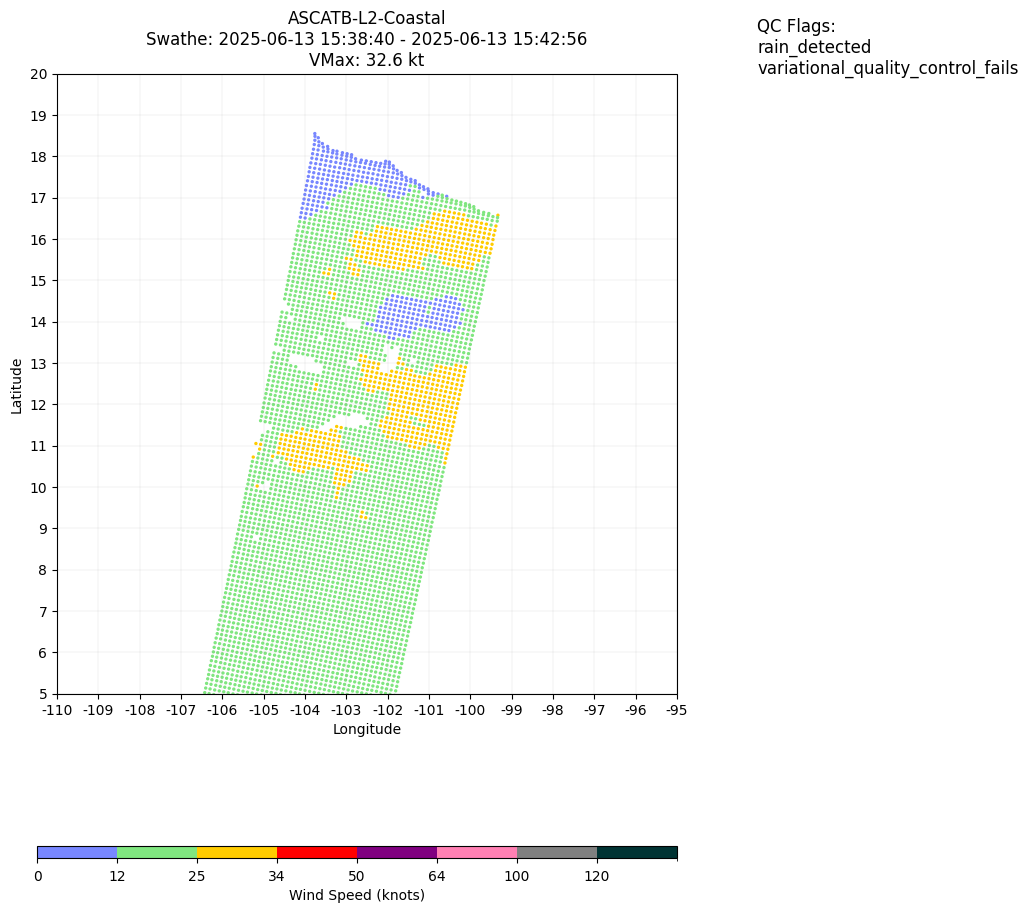

In [131]:
qc_flags = [
    #'distance_to_gmf_too_large',
    #'data_are_redundant',
    #'no_meteorological_background_used',
    'rain_detected',
    #'not_usable_for_visualisation',
    #'small_wind_less_than_or_equal_to_3_m_s',
    #'large_wind_greater_than_30_m_s',
    #'wind_inversion_not_successful',
    #'some_portion_of_wvc_is_over_ice',
    #'some_portion_of_wvc_is_over_land',
    'variational_quality_control_fails',
    #'knmi_quality_control_fails',
    #'product_monitoring_event_flag',
    #'product_monitoring_not_used',
    #'any_beam_noise_content_above_threshold',
    #'poor_azimuth_diversity',
    #'not_enough_good_sigma0_for_wind_retrieval'
]

plot_ascat(file_path, metric, lon_min, lon_max, lat_min, lat_max, qc_flags)

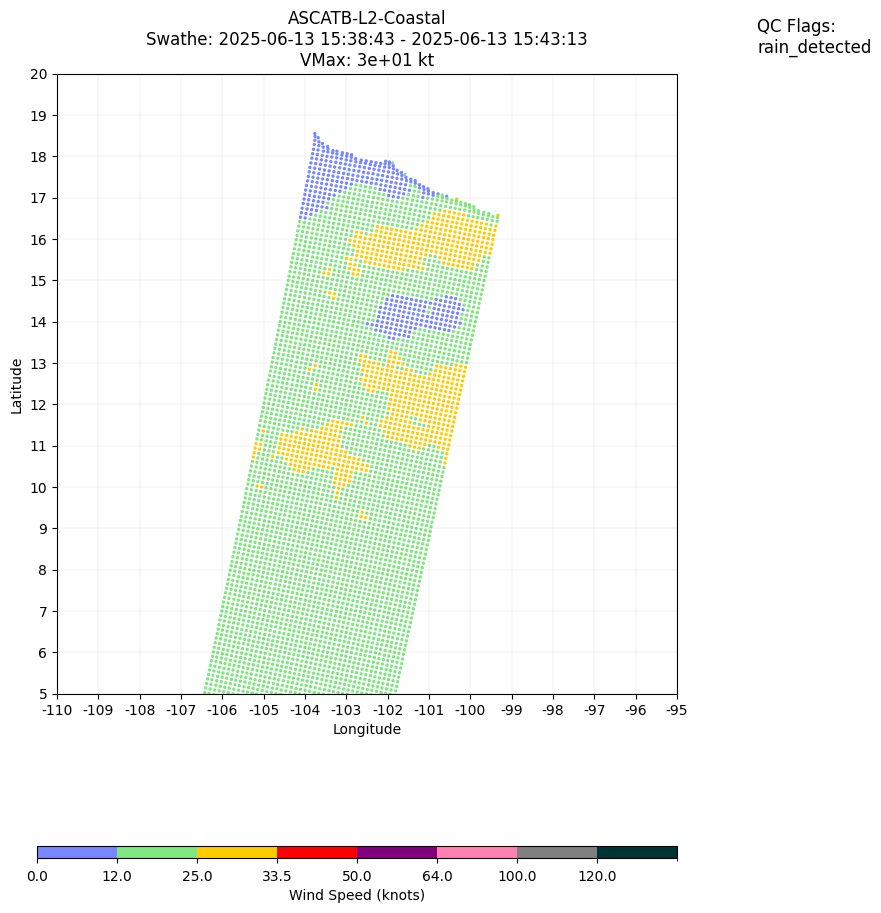

In [109]:
qc_flags = [
    #'distance_to_gmf_too_large',
    #'data_are_redundant',
    #'no_meteorological_background_used',
    'rain_detected',
    #'not_usable_for_visualisation',
    #'small_wind_less_than_or_equal_to_3_m_s',
    #'large_wind_greater_than_30_m_s',
    #'wind_inversion_not_successful',
    #'some_portion_of_wvc_is_over_ice',
    #'some_portion_of_wvc_is_over_land',
    #'variational_quality_control_fails',
    #'knmi_quality_control_fails',
    #'product_monitoring_event_flag',
    #'product_monitoring_not_used',
    #'any_beam_noise_content_above_threshold',
    #'poor_azimuth_diversity',
    #'not_enough_good_sigma0_for_wind_retrieval'
]

plot_ascat(file_path, metric, lon_min, lon_max, lat_min, lat_max, qc_flags)

{'time': <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    units: seconds since 1970-01-01 00:00:00Z
    calendar: gregorian
    standard_name: time
    long_name: Centered Time
    bounds: time_bounds
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'altitude': <class 'netCDF4._netCDF4.Variable'>
float64 altitude(altitude)
    units: m
    standard_name: height
    positive: up
    axis: Z
unlimited dimensions: 
current shape = (1,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'rows': <class 'netCDF4._netCDF4.Variable'>
float64 rows(rows)
    units: degrees_north
    standard_name: latitude
    long_name: Latitude of Pixel Centers
    axis: Y
unlimited dimensions: 
current shape = (540,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'cols': <class 'netCDF4._netCDF4.Variable'>
float64 cols(cols)
    units: degrees_east
    standard_name: longitude
    long_name: Longitude of Pixel Centers

/home/db/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1762: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


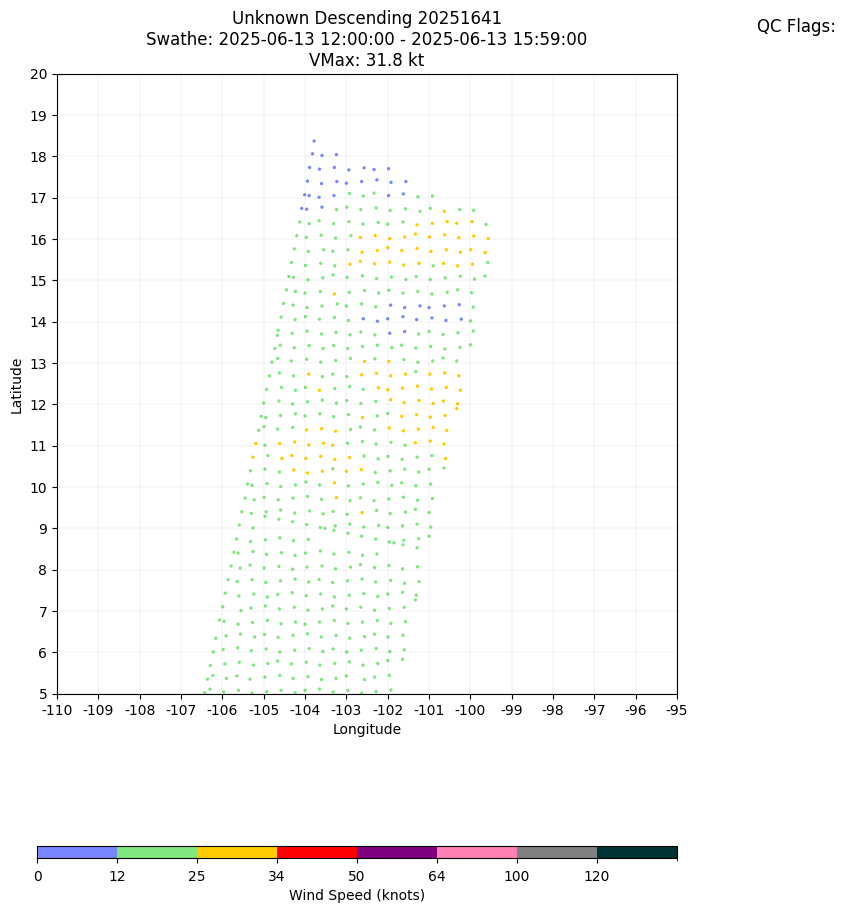

In [34]:
qc_flags = [
    #'distance_to_gmf_too_large',
    #'data_are_redundant',
    #'no_meteorological_background_used',
    #'rain_detected',
    #'not_usable_for_visualisation',
    #'small_wind_less_than_or_equal_to_3_m_s',
    #'large_wind_greater_than_30_m_s',
    #'wind_inversion_not_successful',
    #'some_portion_of_wvc_is_over_ice',
    #'some_portion_of_wvc_is_over_land',
    #'variational_quality_control_fails',
    #'knmi_quality_control_fails',
    #'product_monitoring_event_flag',
    #'product_monitoring_not_used',
    #'any_beam_noise_content_above_threshold',
    #'poor_azimuth_diversity',
    #'not_enough_good_sigma0_for_wind_retrieval'
]

plot_ascat(file_path, metric, lon_min, lon_max, lat_min, lat_max, qc_flags)

In [ ]:
import eccodes

def read_bufr_file(file_path):
    with open(file_path, 'rb') as f:
        while True:
            try:
                # Read BUFR message
                bufr_id = eccodes.codes_bufr_new_from_file(f)
                print("test")
                if bufr_id is None:
                    break
                print("0")
                # Unpack descriptors
                eccodes.codes_set(bufr_id, 'unpack', 1)
                print("test")

                # Get list of available keys
                keys_iter = eccodes.codes_keys_iterator_new(bufr_id)
                keys = []

                while eccodes.codes_keys_iterator_next(keys_iter):
                    key_name = eccodes.codes_keys_iterator_get_name(keys_iter)
                    keys.append(key_name)

                eccodes.codes_keys_iterator_delete(keys_iter)

                # Print values of available keys
                for key in keys:
                    try:
                        value = eccodes.codes_get(bufr_id, key)
                        print(f"{key}: {value}")
                    except eccodes.CodesInternalError:
                        pass  # Some keys might not return values

                eccodes.codes_release(bufr_id)

            except eccodes.CodesInternalError as err:
                print("Error:", err)
                break

read_bufr_file("OASWC12_20250613_145400_66090_M01.bufr")
